This notebook analyses the popular image dataset- MNIST.
This involves binary classification using logistic regression and KNN, comparing accuracy of both types of models, followed with the construction of a Neural Network that classifies the MNIST data quite accurately. 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

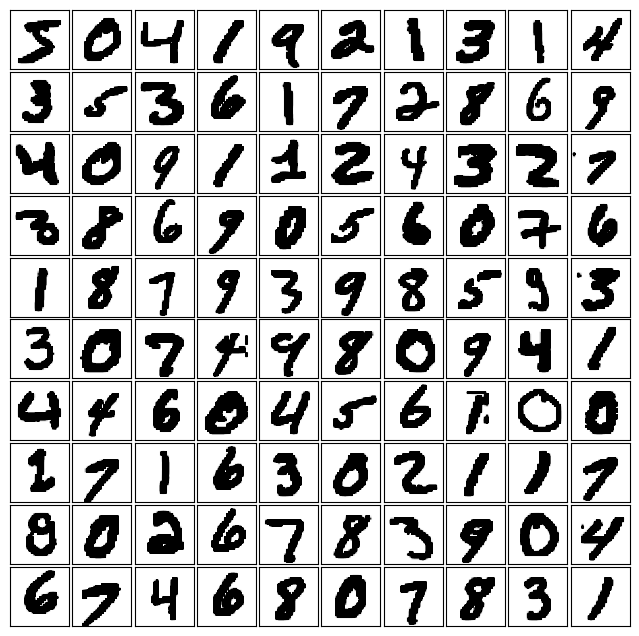

In [ ]:
plot_digits(mnist.data.values)

In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000]
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
print(mnist_training_labels)

['5', '0', '4', '1', '9', ..., '8', '3', '5', '6', '8']
Length: 60000
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [ ]:
mnist_training_label_is_lucky = np.expand_dims(1.0*(np.logical_or(np.logical_or(mnist_training_labels=='3',mnist_training_labels=='7'),mnist_training_labels=='8')), 1)
mnist_testing_label_is_lucky = np.expand_dims(1.0*(np.logical_or(np.logical_or(mnist_testing_labels=='3', mnist_testing_labels=='7'),mnist_testing_labels=='8')), 1)

print(mnist_training_data.shape)
print(mnist_training_label_is_lucky.shape)

(60000, 784)
(60000, 1)


In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_is_lucky)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_label_is_lucky)

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

In [ ]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

In [ ]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

In [ ]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

In [ ]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        return x

In [ ]:
def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

Loaded Data
Epoch [1/30], Train Loss: 0.3060, Test Loss: 0.3012
Epoch [6/30], Train Loss: 0.3041, Test Loss: 0.3012
Epoch [11/30], Train Loss: 0.3041, Test Loss: 0.3012
Epoch [16/30], Train Loss: 0.3041, Test Loss: 0.3012
Epoch [21/30], Train Loss: 0.3041, Test Loss: 0.3012
Epoch [26/30], Train Loss: 0.3041, Test Loss: 0.3012


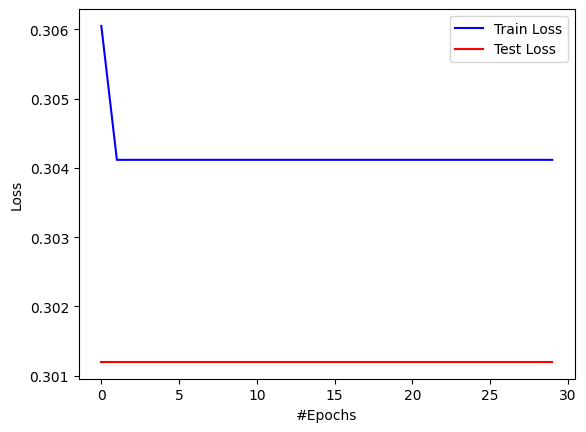

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 41753/60000 (69.6%)

Train Set: Accuracy: 6988/10000 (69.9%)


Linear Regression
AUC: 0.42326527224435595
Precision [0.6988 0.    ]
Recall [1. 0.]
F1 [0.82269838 0.        ]
Count [6988 3012]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


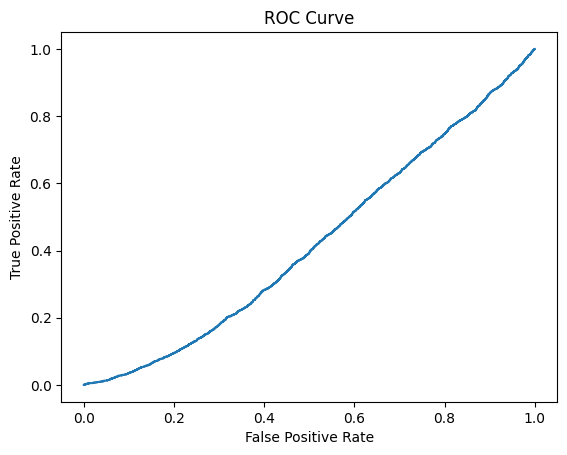

In [ ]:
preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(mnist_testing_label_is_lucky,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("Linear Regression")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(mnist_testing_label_is_lucky,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

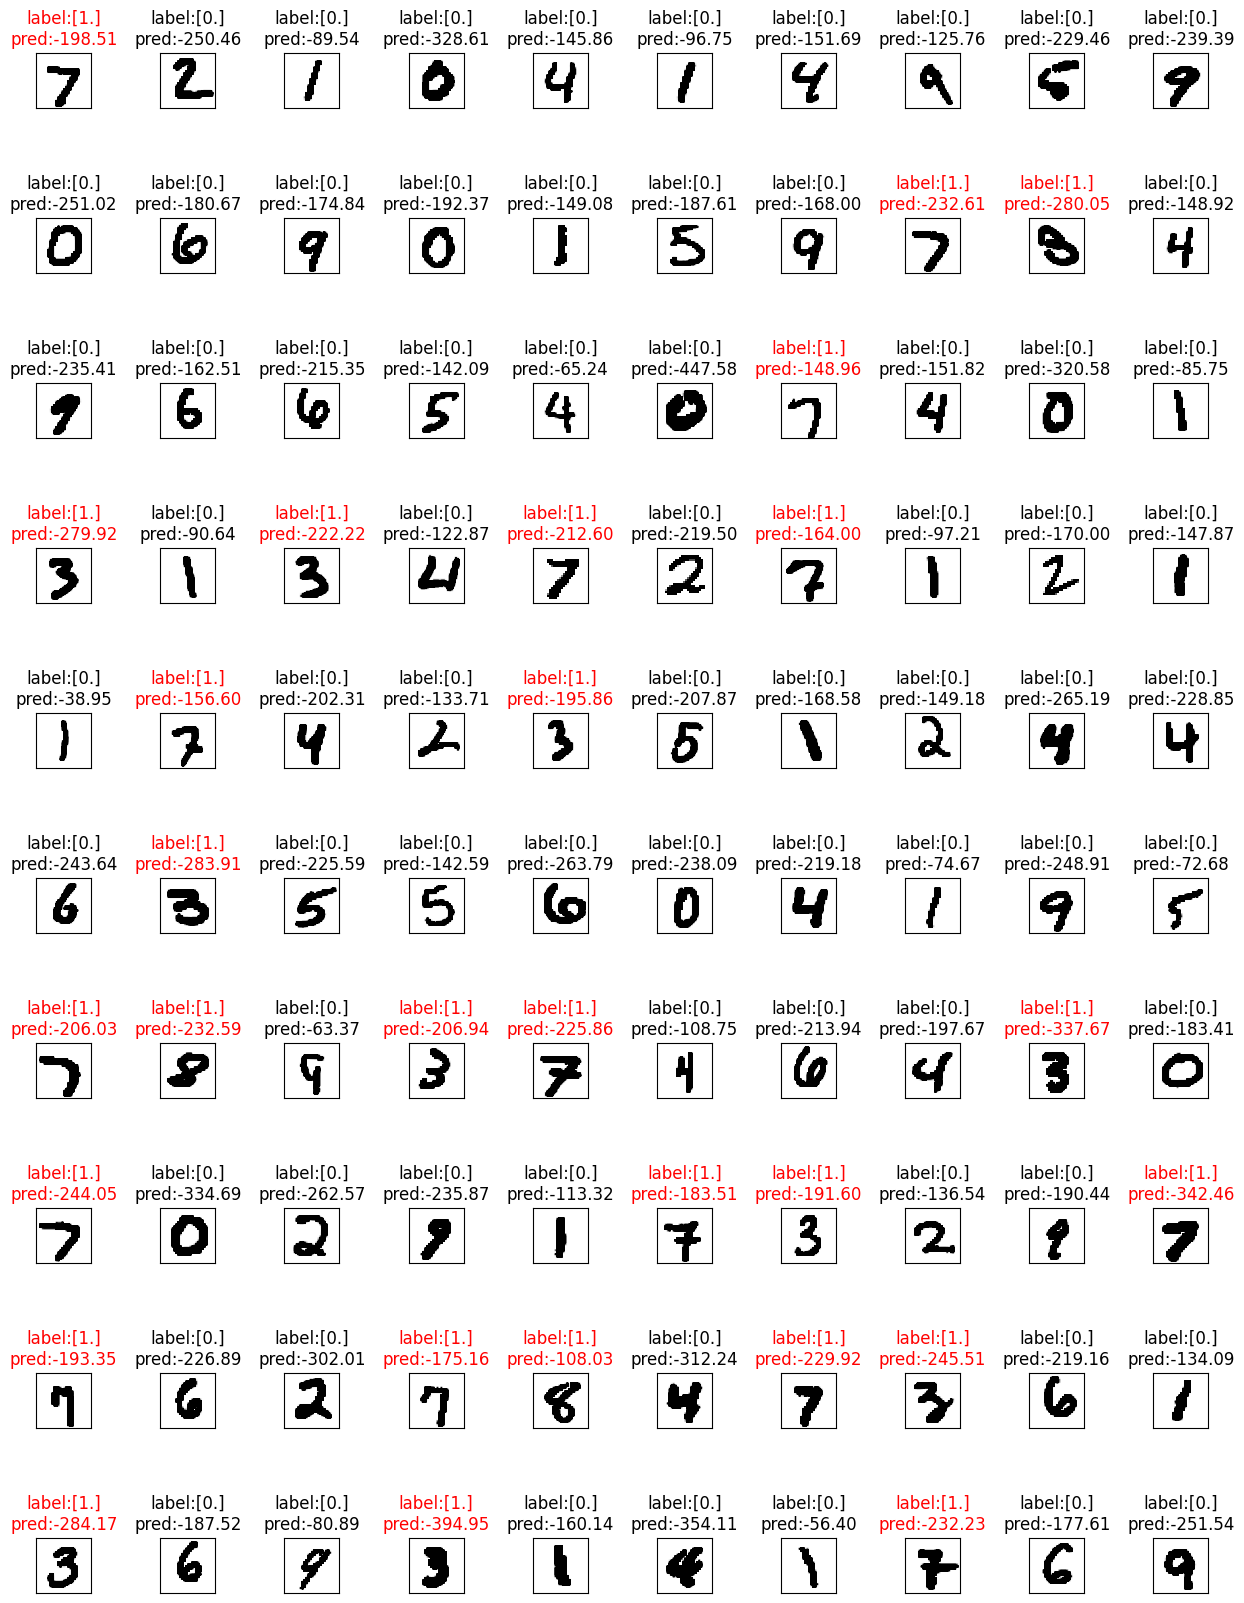

In [ ]:
plot_digits_with_predictions(model,mnist_testing_data,mnist_testing_label_is_lucky)

In [ ]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
mnist_training_label_is_lucky_knn = 1.0*(np.logical_or(np.logical_or(mnist_training_labels=='3',mnist_training_labels=='7'),mnist_training_labels=='8'))
mnist_testing_label_is_lucky_knn = 1.0*(np.logical_or(np.logical_or(mnist_testing_labels=='3', mnist_testing_labels=='7'),mnist_testing_labels=='8'))

In [ ]:
# accuracy = []
# for i in range(1,51):
#   knn = KNeighborsClassifier(n_neighbors=i)
#   knn.fit(mnist_training_data,mnist_training_label_is_lucky_knn)
#   predictions = knn.predict(mnist_testing_data)
#   accuracy.append(accuracy_score(mnist_testing_label_is_lucky_knn, predictions))
# print(accuracy)

In [ ]:
# print(max(accuracy))

KNN
AUC: 0.9797506216310108
Precision [0.9857894  0.98278772]
Recall [0.99270177 0.96679947]
F1 [0.98923351 0.97472803]
Count [6988 3012]


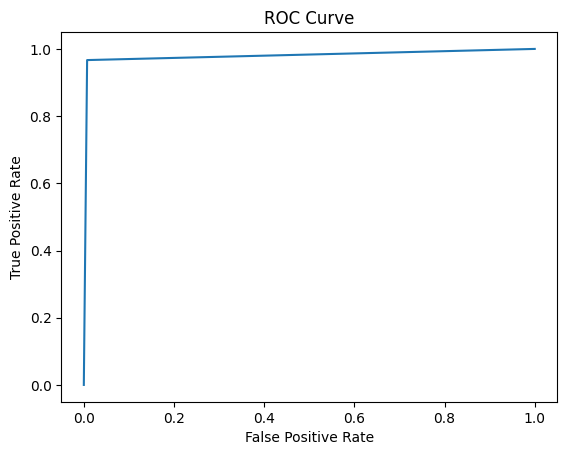

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(mnist_training_data,mnist_training_label_is_lucky_knn)
preds = knn.predict(mnist_testing_data)
fpr, tpr, thresholds = metrics.roc_curve(mnist_testing_label_is_lucky_knn,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("KNN")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(mnist_testing_label_is_lucky_knn,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
mnist_training_labels.to_numpy()

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [ ]:
mnist_training_labels.to_numpy().astype(int)

array([5, 0, 4, ..., 5, 6, 8])

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int))

tensor([5., 0., 4.,  ..., 5., 6., 8.])

In [ ]:
torch.Tensor(mnist_training_labels.to_numpy().astype(int)).long()

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long())

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

In [ ]:
mnist_training_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_catigories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_catigories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_catigories)

In [ ]:
class Classifier_3Lyares(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)
        self.linear3 = nn.Linear(15, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = F.relu(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

For the digit classification, i created a multi-layer NN with 3 layers using non linear transformations such as relu and abs for the first 2 layers and the third layer as is so it wouldn’t just give me a batch of 0s and 1s. I used cross entropy as my loss function and trained it through 30 epochs to minimize loss after which my testing and training loss looked pretty good.


Loaded Data
Epoch [1/30], Train Loss: 0.7313, Test Loss: 0.3388
Epoch [6/30], Train Loss: 0.1974, Test Loss: 0.2054
Epoch [11/30], Train Loss: 0.1605, Test Loss: 0.2015
Epoch [16/30], Train Loss: 0.1451, Test Loss: 0.1928
Epoch [21/30], Train Loss: 0.1359, Test Loss: 0.1906
Epoch [26/30], Train Loss: 0.1252, Test Loss: 0.1829


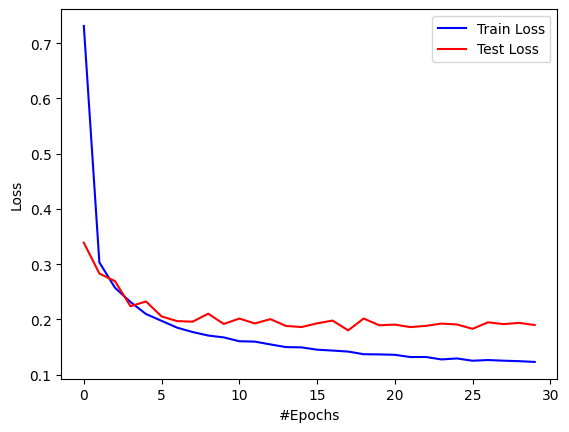

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = Classifier_3Lyares(image_w, image_h, 10)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 57906/60000 (96.5%)

Train Set: Accuracy: 9486/10000 (94.9%)


In [ ]:
def plot_digits_with_mnist_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

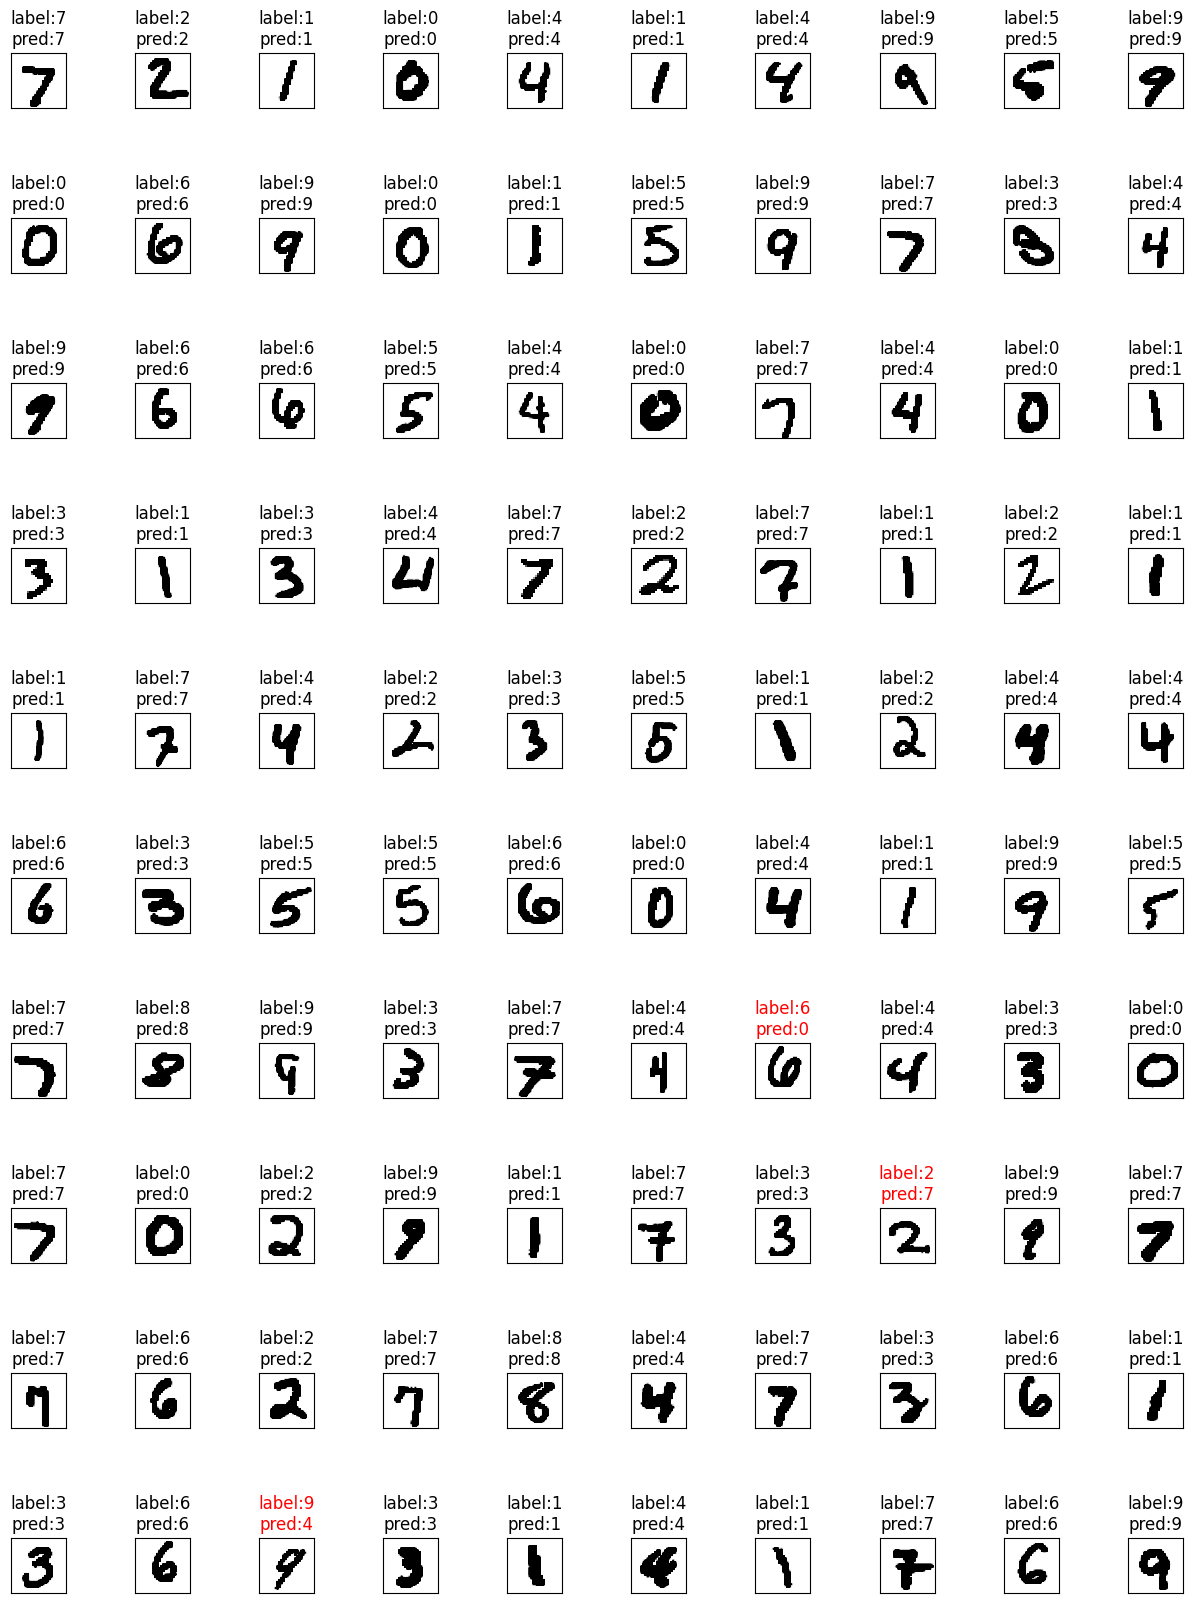

In [ ]:
plot_digits_with_mnist_predictions(model, mnist_testing_data, mnist_testing_labels_catigories)

Visual Analysis of DATA

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#pred_probs = model(torch.Tensor(mnist_testing_data))

pred_probs = torch.nn.functional.softmax(model(torch.Tensor(mnist_testing_data)), dim=1)
pred_probs_np = pred_probs.detach().numpy()
#pred_probs_np = pred_probs.detach().numpy()
#best_matches = pred_probs_np.argmax(0)
best_matches = pred_probs_np.argmax(0)
pred_probs

tensor([[1.7569e-06, 2.7527e-05, 1.4083e-04,  ..., 9.9951e-01, 6.8622e-05,
         5.1756e-06],
        [1.4242e-13, 3.6482e-04, 9.9948e-01,  ..., 2.5892e-07, 1.5752e-09,
         1.0139e-11],
        [1.1217e-07, 9.9991e-01, 2.4567e-08,  ..., 3.2998e-06, 7.1057e-05,
         3.2014e-08],
        ...,
        [8.5488e-09, 3.3416e-11, 2.0684e-09,  ..., 1.2421e-07, 5.0769e-09,
         3.2394e-05],
        [2.2788e-11, 1.9224e-10, 2.7191e-06,  ..., 2.2932e-14, 2.6350e-04,
         6.6791e-09],
        [2.9450e-07, 2.5181e-15, 1.5833e-06,  ..., 1.9649e-12, 2.2185e-08,
         1.2676e-16]], grad_fn=<SoftmaxBackward0>)

In [ ]:
pred_probs.shape

torch.Size([10000, 10])

In [ ]:
print(best_matches)

[8056 1515 1049  686   85  102  131  262 8015 5977]


In [ ]:
torch.set_printoptions(sci_mode=False)

In [ ]:
pred_probs_np[:,0]

array([1.7568944e-06, 1.4241680e-13, 1.1216511e-07, ..., 8.5488345e-09,
       2.2788320e-11, 2.9450328e-07], dtype=float32)

In [ ]:
label_zero = (mnist_testing_labels == '0')

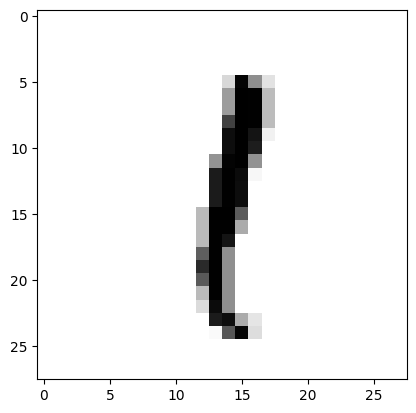

In [ ]:
plt.imshow(mnist_testing_data[4021].reshape(28, 28), cmap='Greys')

In [ ]:
model(torch.Tensor(mnist_testing_data[8089]))

tensor([[-3.7861,  0.4075, 14.2696, 30.4482, 14.3115, 53.3245,  1.1962, -2.6074,
         28.7377, 23.3143]], grad_fn=<AddmmBackward0>)

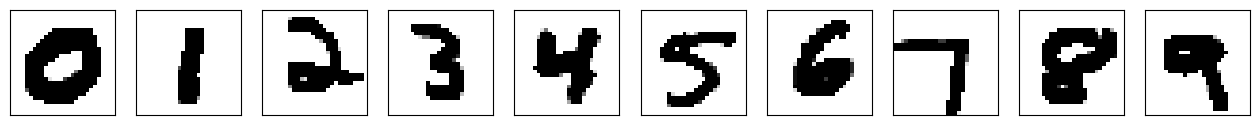

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(16, 20),subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
        if i < best_matches.shape[0]:
          im = axi.imshow(mnist_testing_data[best_matches[i]].reshape(28, 28), cmap='Greys')
          #pred_label = model(torch.tensor(mnist_testing_data[i]).float()).max(1, keepdim=True)[1].item()
          #true_label = np.argmax(mnist_testing_labels_catigories[i])
          #drawColor = 'black'
          #if pred_label != true_label:
          #  drawColor = 'red'
        im.set_clim(0, 16)

Text(70.72222222222221, 0.5, 'Predicted Class')

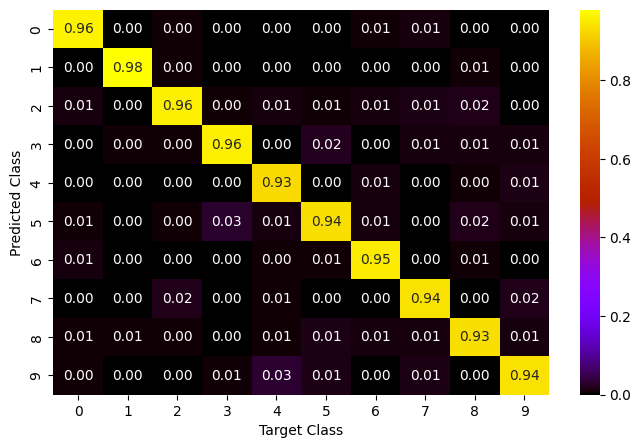

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")